# Imports

In [1]:
from dqn.dqn import QNetwork, ReplayMemory
from policies.eps_greedy import EpsilonGreedyPolicy
from train_eval.train import train

import random
import numpy as np
import torch
from torch import optim
import gym
import matplotlib.pyplot as plt

# Load the environment

In [2]:
env = gym.envs.make("CartPole-v1")

C:\Users\kylia\Anaconda3\envs\rl2020\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


# Create DQN and policy

In [3]:
seed = 42  # This is not randomly chosen
num_hidden = 128
eps = 0.05

# We will seed the algorithm (before initializing QNetwork!) for reproducibility
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

Q_net = QNetwork(num_hidden=num_hidden)
policy = EpsilonGreedyPolicy(Q_net, eps)

# Function to run episodes and call training function (with replay memory)

In [4]:
def run_episodes(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, optimizer):
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []
    state_values = []
    init_state = env.reset()
    for i in range(num_episodes):
        state = env.reset()

        steps = 0
        while True:
            # Set epsilon according to number of steps
            policy.set_epsilon(global_steps)
            # Sample an action, next state, reward and done
            a = policy.sample_action(state)
            s_next, r, done, _ = env.step(a)
            # Add the transition to the memory buffer
            memory.push((state, a, r, s_next, done))
            # Perform training on the buffer
            loss = train(Q, memory, optimizer, batch_size, discount_factor)
            # Increase step counts and set current state
            steps += 1
            global_steps += 1
            state = s_next
            
            if global_steps % 100 == 0:
                with torch.no_grad():
                    Q.eval()
                    Q_vals = Q(torch.Tensor([init_state]))
                    maxx, _ = torch.max(Q_vals, dim=1)
                    state_values.append(maxx)

            if done:
                if i % 10 == 0:
                    print("{2} Episode {0} finished after {1} steps"
                          .format(i, steps, '\033[92m' if steps >= 195 else '\033[99m'))
                episode_durations.append(steps)
                break
    return episode_durations, state_values

# Perform training

In [5]:
num_episodes = 200
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
# To switch off Replay Memory mechanism, simply set size to batch size
memory = ReplayMemory(10000)

optimizer = optim.Adam(Q_net.parameters(), learn_rate)
episode_durations, state_values = run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, optimizer)

 Episode 0 finished after 11 steps
 Episode 10 finished after 20 steps
 Episode 20 finished after 10 steps
 Episode 30 finished after 17 steps
 Episode 40 finished after 42 steps
 Episode 50 finished after 113 steps
 Episode 60 finished after 500 steps
 Episode 70 finished after 354 steps
 Episode 80 finished after 500 steps
 Episode 90 finished after 405 steps
 Episode 100 finished after 372 steps
 Episode 110 finished after 238 steps
 Episode 120 finished after 36 steps
 Episode 130 finished after 118 steps
 Episode 140 finished after 260 steps
 Episode 150 finished after 207 steps
 Episode 160 finished after 323 steps
 Episode 170 finished after 122 steps
 Episode 180 finished after 500 steps
 Episode 190 finished after 290 steps


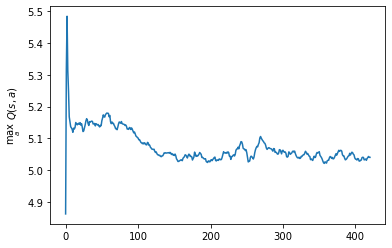

In [6]:
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(smooth(np.array(state_values), 10))
plt.ylabel('$\max_a\ Q(s,a)$')
plt.show()

# Function to run episodes and call training function (without replay memory)

In [7]:
def run_episodes(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, optimizer):
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    state_values = []
    init_state = env.reset()
    for i in range(num_episodes):
        state = env.reset()

        steps = 0
        while True:
            # Set epsilon according to number of steps
            policy.set_epsilon(global_steps)
            # Increase step counts
            steps += 1
            global_steps += 1
            # Sample an action, next state, reward and done
            a = policy.sample_action(state)
            s_next, r, done, _ = env.step(a)
            # Add the transition to the memory buffer
            memory.push((state, a, r, s_next, done))
            # Perform training on the buffer
            if global_steps % batch_size == 0:
                loss = train(Q, memory, optimizer, batch_size, discount_factor)
            state = s_next
            
            if global_steps % 100 == 0:
                with torch.no_grad():
                    Q.eval()
                    Q_vals = Q(torch.Tensor([init_state]))
                    maxx, _ = torch.max(Q_vals, dim=1)
                    state_values.append(maxx)

            if done:
                if i % 100 == 0:
                    print("{2} Episode {0} finished after {1} steps"
                          .format(i, steps, '\033[92m' if steps >= 195 else '\033[99m'))
                episode_durations.append(steps)
                break
    return episode_durations, state_values

In [8]:
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

Q_net = QNetwork(num_hidden=num_hidden)
policy = EpsilonGreedyPolicy(Q_net, eps)

num_episodes = 10000
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(batch_size)

optimizer = optim.Adam(Q_net.parameters(), learn_rate)
episode_durations, state_values = run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, optimizer)

 Episode 0 finished after 11 steps
 Episode 100 finished after 10 steps
 Episode 200 finished after 10 steps
 Episode 300 finished after 9 steps
 Episode 400 finished after 9 steps
 Episode 500 finished after 9 steps
 Episode 600 finished after 9 steps
 Episode 700 finished after 10 steps
 Episode 800 finished after 10 steps
 Episode 900 finished after 9 steps
 Episode 1000 finished after 10 steps
 Episode 1100 finished after 10 steps
 Episode 1200 finished after 8 steps
 Episode 1300 finished after 8 steps
 Episode 1400 finished after 9 steps
 Episode 1500 finished after 11 steps
 Episode 1600 finished after 11 steps
 Episode 1700 finished after 10 steps
 Episode 1800 finished after 9 steps
 Episode 1900 finished after 9 steps
 Episode 2000 finished after 10 steps
 Episode 2100 finished after 9 steps
 Episode 2200 finished after 10 steps
 Episode 2300 finished after 8 steps
 Episode 2400 finished after 10 steps
 Episode 2500 finished after 9 steps
 Episode 2600 finished after 9 steps


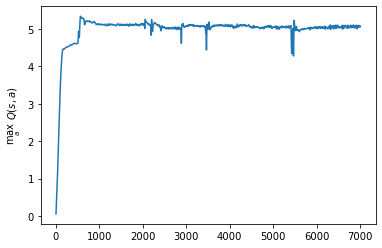

In [9]:
plt.plot(smooth(np.array(state_values), 10))
plt.ylabel('$\max_a\ Q(s,a)$')
plt.show()